In [1]:
## running once
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
from toolz.curried import *
import matplotlib.pyplot as plt
import seaborn as sns

## Loading dataset

In [3]:
from util import *

In [4]:
df = pd.read_csv('carpark_data_06_01-21')
df.head()

,sid,tid,AvailableLots,date,min,Weekday,Agency
0,0,0,2797.0,2021-06-01 00:00:00,0,1,0
1,0,1,2797.0,2021-06-01 00:01:00,0,1,0
2,0,2,2797.0,2021-06-01 00:02:00,0,1,0
3,0,3,2797.0,2021-06-01 00:03:00,0,1,0
4,0,4,2797.0,2021-06-01 00:04:00,0,1,0


In [5]:
df['min']=df['min'].astype(str) 
df['Weekday']=df['Weekday'].astype(str) 
df['Agency']=df['Agency'].astype(str) 

In [6]:
dp = df[df.tid%5==0]
dp.loc[:, 'tid'] = dp['tid']//5
dp.head()

/home_nfs/jiangyue/anaconda3/envs/pytorch-gpu/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,sid,tid,AvailableLots,date,min,Weekday,Agency
0,0,0,2797.0,2021-06-01 00:00:00,0,1,0
5,0,1,2799.0,2021-06-01 00:05:00,1,1,0
10,0,2,2803.0,2021-06-01 00:10:00,2,1,0
15,0,3,2805.0,2021-06-01 00:15:00,3,1,0
20,0,4,2804.0,2021-06-01 00:20:00,4,1,0


In [7]:
carpark_data_uni = dp
carpark_data_HDB = dp[dp.Agency == '1']
carpark_data_non_HDB = dp[dp.Agency != '1']

## Forecasting

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch
from torch.utils.data import DataLoader

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE
from dataloader import subset_sampler

In [10]:
# carpark_data_s=carpark_data[carpark_data.sid==1000]

In [11]:
context_length = 12*12
prediction_length = 2*12

training_cutoff = 17*24*12
validation_cutoff = 19*24*12
test_cutoff = 21*24*12

training = TimeSeriesDataSet(
    carpark_data_uni[lambda x: x.tid <= training_cutoff],
    time_idx="tid",
    group_ids=["sid"],
    target="AvailableLots",
    time_varying_unknown_reals=["AvailableLots"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    static_categoricals = ["Agency"],
    time_varying_known_categoricals=["min", "Weekday"],
)

validation = TimeSeriesDataSet.from_dataset(
    training,                                         
    carpark_data_uni[lambda x: x.tid <= validation_cutoff],
    min_prediction_idx=training_cutoff + 1
)

test = TimeSeriesDataSet.from_dataset(
    training, 
    carpark_data_uni,
    min_prediction_idx=validation_cutoff + 1
)

In [12]:
train_sampler = subset_sampler(training, 0.5, random=True)
val_sampler = subset_sampler(validation, 0.05)
test_sampler = subset_sampler(test, 0.05)
# train_sampler = subset_sampler(training, 0.5, random=True)
# val_sampler = subset_sampler(validation, 0.05)
# test_sampler = subset_sampler(test, 0.05)

In [13]:
batch_size = 200
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, 
                                          num_workers=8)                                          
val_dataloader = validation.to_dataloader(batch_size=500, num_workers=8,
                                          shuffle=False, sampler=val_sampler)                                          
test_dataloader = test.to_dataloader(batch_size=500, num_workers=8,
                                     shuffle=False, sampler=test_sampler)            
# train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, 
#                                           num_workers=8)                                          
# val_dataloader = validation.to_dataloader(batch_size=50, num_workers=8,
#                                           shuffle=False, sampler=val_sampler)                                          
# test_dataloader = test.to_dataloader(batch_size=50, num_workers=8,
#                                      shuffle=False, sampler=test_sampler)                                                                  

In [14]:
print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

43586
101
101


In [15]:
# x_trn, y_trn = first(train_dataloader)
# x_val, y_val = first(val_dataloader)
# x_tst, y_tst = first(test_dataloader)

# x_trn["encoder_cat"].shape

# x_trn["decoder_cont"].shape

# x_trn["decoder_target"]

# rnn.output_transformer(dict(prediction=x_trn["decoder_cont"],
#                             target_scale=x_trn["target_scale"])).squeeze()
# training.target_normalizer(dict(prediction=x_trn["decoder_cont"],
#                                 target_scale=x_trn["target_scale"])).squeeze()

In [16]:
#training.index

In [17]:
# from pytorch_forecasting import Baseline

# baseline_predictions = Baseline().predict(test_dataloader)

# abs_error = torch.abs(baseline_predictions - actuals)

# print(torch.mean(abs_error * mask))
# errors = torch.mean(abs_error * mask, dim=0)

# mape = abs_error / (actuals + 1e-5)

# print(torch.mean(mape * mask))
# mapes = torch.mean(mape * mask, dim=0)

# plt.plot(torch.arange(1, len(errors)+1), errors, ".-")
# plt.xlabel("Time steps")
# plt.ylabel("MAE")

# plt.plot(torch.arange(1, len(mapes)+1), mapes, ".-")
# plt.xlabel("Time steps")
# plt.ylabel("MAPE")

In [18]:
actuals = torch.cat([y[0] for _, y in iter(test_dataloader)])
mask = actuals > 1.0

### LSTM

In [10]:
from models import RNN

In [20]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, 
                                    patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=50,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=500
)

rnn = RNN.from_dataset(
    training,
    embedding_sizes={"min": (1440 // 5, 91), "Weekday": (7, 20), "Agency": (2,2)},
    # embedding_sizes={"min": (1440 // 5, 91)},
    cell_type="GRU",
    hidden_size=50,
    learning_rate=1e-3,
    log_interval=50,
    log_val_interval=50,
    weight_decay=1e-3,
)

#rnn

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [21]:
print(rnn.lagged_target_positions)

{}


In [22]:
trainer.fit(
    rnn,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAE            | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 26.4 K
3 | rnn              | GRU            | 40.2 K
4 | output_projector | Linear         | 51    
----------------------------------------------------
66.6 K    Trainable params
0         Non-trainable params
66.6 K    Total params
0.266     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [23]:
rnn.hparams

"categorical_groups":                {}
"cell_type":                         GRU
"dropout":                           0.1
"embedding_labels":                  {'Agency': {'0': 0, '1': 1}, 'min': {'0': 0, '1': 1, '10': 2, '100': 3, '101': 4, '102': 5, '103': 6, '104': 7, '105': 8, '106': 9, '107': 10, '108': 11, '109': 12, '11': 13, '110': 14, '111': 15, '112': 16, '113': 17, '114': 18, '115': 19, '116': 20, '117': 21, '118': 22, '119': 23, '12': 24, '120': 25, '121': 26, '122': 27, '123': 28, '124': 29, '125': 30, '126': 31, '127': 32, '128': 33, '129': 34, '13': 35, '130': 36, '131': 37, '132': 38, '133': 39, '134': 40, '135': 41, '136': 42, '137': 43, '138': 44, '139': 45, '14': 46, '140': 47, '141': 48, '142': 49, '143': 50, '144': 51, '145': 52, '146': 53, '147': 54, '148': 55, '149': 56, '15': 57, '150': 58, '151': 59, '152': 60, '153': 61, '154': 62, '155': 63, '156': 64, '157': 65, '158': 66, '159': 67, '16': 68, '160': 69, '161': 70, '162': 71, '163': 72, '164': 73, '165': 74, 

In [24]:
device = torch.device("cuda:0")
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = RNN.load_from_checkpoint(best_model_path).to(device)
print(best_model_path)
print(best_model.device)

/home_nfs/jiangyue/github/carpark-prediction/lightning_logs/version_73/checkpoints/epoch=3-step=1999.ckpt
cuda:0


In [25]:
%%time
predictions = best_model.predict(test_dataloader, batch_size=500, show_progress_bar=True)
print(predictions.shape)

Predict:   0%|          | 0/101 [00:00<?, ? batches/s]

torch.Size([50500, 24])
CPU times: user 2.85 s, sys: 3.98 s, total: 6.83 s
Wall time: 8.84 s


In [26]:
abs_error = torch.abs(predictions - actuals)

In [27]:
abs_error.shape

torch.Size([50500, 24])

In [28]:
print(torch.mean(abs_error * mask))
abs_error_steps = torch.mean(abs_error * mask, dim=0)

tensor(6.8898)


In [29]:
abs_error_steps.shape

torch.Size([24])

In [30]:
mape = abs_error / (actuals + 1e-5)

In [31]:
print(torch.mean(mape * mask))
mape_steps = torch.mean(mape * mask, dim=0)

tensor(0.1051)


Text(0, 0.5, 'MAE')

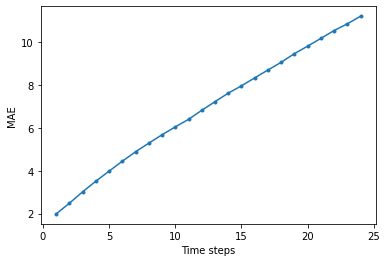

In [32]:
plt.plot(torch.arange(1, len(abs_error_steps)+1), abs_error_steps, ".-")
plt.xlabel("Time steps")
plt.ylabel("MAE")
#plt.xlim([1, 120])
#plt.xticks([1, 20, 40, 60, 80, 100, 120]);

In [33]:
abs_error_steps

tensor([ 1.9839,  2.4832,  3.0152,  3.5110,  3.9779,  4.4413,  4.8825,  5.2828,
         5.6747,  6.0410,  6.3920,  6.8141,  7.2163,  7.6132,  7.9550,  8.3255,
         8.6918,  9.0512,  9.4553,  9.8045, 10.1656, 10.5323, 10.8461, 11.1996])

Text(0, 0.5, 'MAPE')

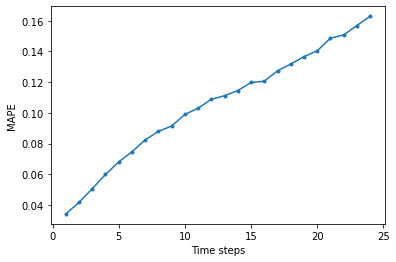

In [34]:
plt.plot(torch.arange(1, len(mape_steps)+1), mape_steps, ".-")
plt.xlabel("Time steps")
plt.ylabel("MAPE")
#plt.xlim([1, 120])
#plt.xticks([1, 20, 40, 60, 80, 100, 120]);

In [35]:
n = abs_error.shape[0]

In [36]:
step = 6 # 30 mins later

abs_error_step = abs_error[:, step-1] * mask[:, step-1]

σ, μ = torch.std_mean(abs_error_step)
print(f"μ = {μ:.4f}, σ = {σ:.4f}, max = {abs_error_step.max():.4f}")
xs = abs_error_step[torch.randperm(n)[:1000]].cpu().numpy()

μ = 4.4413, σ = 8.7592, max = 803.4690


In [37]:
abs_error_step.shape

torch.Size([50500])

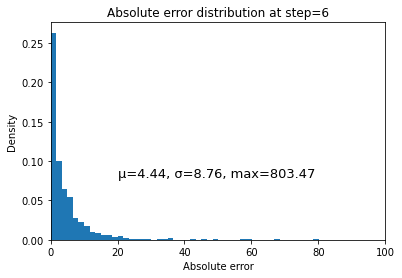

In [38]:
n = len(abs_error_step)
plt.hist(xs, 100, density=True)
plt.xlim(0, 100)
plt.xlabel("Absolute error")
plt.ylabel("Density")
plt.text(20, 0.08, f"μ={μ:.2f}, σ={σ:.2f}, max={abs_error_step.max():.2f}",
         fontsize=13)
plt.title(f"Absolute error distribution at step={step}");

Evaluating Different Time Sections

In [11]:
# 
device = torch.device("cuda:0")
# best_model_path="/home_nfs/jiangyue/github/carpark-prediction/lightning_logs/version_33/checkpoints/epoch=2-step=1499.ckpt"
best_model_path="/home_nfs/jiangyue/github/carpark-prediction/lightning_logs/version_73/checkpoints/epoch=3-step=1999.ckpt"
best_model = RNN.load_from_checkpoint(best_model_path).to(device)
print(best_model_path)
print(best_model.device)

/home_nfs/jiangyue/github/carpark-prediction/lightning_logs/version_73/checkpoints/epoch=3-step=1999.ckpt
cuda:0


Predict:   0%|          | 0/6 [00:00<?, ? batches/s]

torch.Size([3000, 24])
tensor(15.4703)
tensor(0.1561)
μ = 8.4119, σ = 10.9150, max = 177.7910, error rate = 0.0329


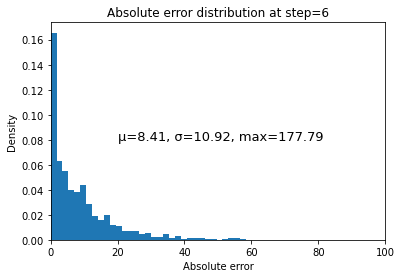

In [12]:
context_length = 12*12
prediction_length = 2*12

training_cutoff = 17*24*12
validation_cutoff = 19*24*12
test_cutoff = 21*24*12

test_HDB = TimeSeriesDataSet(
    carpark_data_HDB[lambda x: x.tid <= 205+288*20+1+3*12+2*12],
    time_idx="tid",
    group_ids=["sid"],
    target="AvailableLots",
    time_varying_unknown_reals=["AvailableLots"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    static_categoricals = ["Agency"],
    time_varying_known_categoricals=["min", "Weekday"],
        min_prediction_idx=205+288*20 + 1
)

test_HDB_sampler = subset_sampler(test_HDB, 0.05)
test_HDB_dataloader = test_HDB.to_dataloader(batch_size=500, num_workers=8,
                                     shuffle=False, sampler=test_HDB_sampler) 
predictions = best_model.predict(test_HDB_dataloader, batch_size=500, show_progress_bar=True)
print(predictions.shape)
actuals = torch.cat([y[0] for _, y in iter(test_HDB_dataloader)])
mask = actuals > 1.0
abs_error = torch.abs(predictions - actuals)
abs_error.shape
print(torch.mean(abs_error * mask))
abs_error_steps = torch.mean(abs_error * mask, dim=0)
abs_error_steps.shape
mape = abs_error / (actuals + 1e-5)
print(torch.mean(mape * mask))
mape_steps = torch.mean(mape * mask, dim=0)
n = abs_error.shape[0]
step = 6 # 30 mins later

abs_error_step = abs_error[:, step-1] * mask[:, step-1]

σ, μ = torch.std_mean(abs_error_step)
print(f"μ = {μ:.4f}, σ = {σ:.4f}, max = {abs_error_step.max():.4f}, error rate = {μ/carpark_data_HDB.groupby(['sid'])['AvailableLots'].max().mean():.4f}")
xs = abs_error_step[torch.randperm(n)[:1000]].cpu().numpy()
n = len(abs_error_step)
plt.hist(xs, 100, density=True)
plt.xlim(0, 100)
plt.xlabel("Absolute error")
plt.ylabel("Density")
plt.text(20, 0.08, f"μ={μ:.2f}, σ={σ:.2f}, max={abs_error_step.max():.2f}",
         fontsize=13)
plt.title(f"Absolute error distribution at step={step}");

Evaluating the Unified model on HDB dataset and Non-HDB dataset

Predict:   0%|          | 0/94 [00:00<?, ? batches/s]

torch.Size([47000, 24])
tensor(7.4302)
tensor(0.1103)
μ = 4.6085, σ = 8.6278, max = 569.6551, error rate = 0.0180


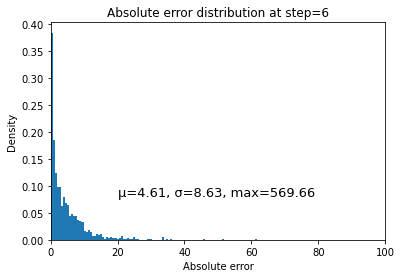

In [56]:
context_length = 12*12
prediction_length = 2*12

training_cutoff = 17*24*12
validation_cutoff = 19*24*12
test_cutoff = 21*24*12

test_HDB = TimeSeriesDataSet(
    carpark_data_HDB,
    time_idx="tid",
    group_ids=["sid"],
    target="AvailableLots",
    time_varying_unknown_reals=["AvailableLots"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    static_categoricals = ["Agency"],
    time_varying_known_categoricals=["min", "Weekday"],
        min_prediction_idx=validation_cutoff + 1
)

test_HDB_sampler = subset_sampler(test_HDB, 0.05)
test_HDB_dataloader = test_HDB.to_dataloader(batch_size=500, num_workers=8,
                                     shuffle=False, sampler=test_HDB_sampler) 
predictions = best_model.predict(test_HDB_dataloader, batch_size=500, show_progress_bar=True)
print(predictions.shape)
actuals = torch.cat([y[0] for _, y in iter(test_HDB_dataloader)])
mask = actuals > 1.0
abs_error = torch.abs(predictions - actuals)
abs_error.shape
print(torch.mean(abs_error * mask))
abs_error_steps = torch.mean(abs_error * mask, dim=0)
abs_error_steps.shape
mape = abs_error / (actuals + 1e-5)
print(torch.mean(mape * mask))
mape_steps = torch.mean(mape * mask, dim=0)
n = abs_error.shape[0]
step = 6 # 30 mins later

abs_error_step = abs_error[:, step-1] * mask[:, step-1]

σ, μ = torch.std_mean(abs_error_step)
print(f"μ = {μ:.4f}, σ = {σ:.4f}, max = {abs_error_step.max():.4f}, error rate = {μ/carpark_data_HDB.groupby(['sid'])['AvailableLots'].max().mean():.4f}")
xs = abs_error_step[torch.randperm(n)[:1000]].cpu().numpy()
n = len(abs_error_step)
plt.hist(xs, 100, density=True)
plt.xlim(0, 100)
plt.xlabel("Absolute error")
plt.ylabel("Density")
plt.text(20, 0.08, f"μ={μ:.2f}, σ={σ:.2f}, max={abs_error_step.max():.2f}",
         fontsize=13)
plt.title(f"Absolute error distribution at step={step}");

Unified model to predict non-HDB dataset

Predict:   0%|          | 0/6 [00:00<?, ? batches/s]

torch.Size([3000, 24])
tensor(11.2208)
tensor(0.2109)
μ = 6.8196, σ = 16.3444, max = 245.3127, error rate = 0.0222


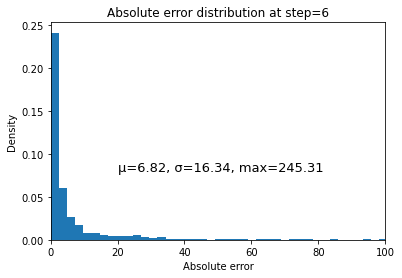

In [57]:
context_length = 12*12
prediction_length = 2*12

training_cutoff = 17*24*12
validation_cutoff = 19*24*12
test_cutoff = 21*24*12

test_non_HDB = TimeSeriesDataSet(
    carpark_data_non_HDB,
    time_idx="tid",
    group_ids=["sid"],
    target="AvailableLots",
    time_varying_unknown_reals=["AvailableLots"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    static_categoricals = ["Agency"],
    time_varying_known_categoricals=["min", "Weekday"],
        min_prediction_idx=validation_cutoff + 1
)

test_non_HDB_sampler = subset_sampler(test_non_HDB, 0.05)
test_non_HDB_dataloader = test_non_HDB.to_dataloader(batch_size=500, num_workers=8,
                                     shuffle=False, sampler=test_non_HDB_sampler) 
predictions = best_model.predict(test_non_HDB_dataloader, batch_size=500, show_progress_bar=True)
print(predictions.shape)
actuals = torch.cat([y[0] for _, y in iter(test_non_HDB_dataloader)])
mask = actuals > 1.0
abs_error = torch.abs(predictions - actuals)
abs_error.shape
print(torch.mean(abs_error * mask))
abs_error_steps = torch.mean(abs_error * mask, dim=0)
abs_error_steps.shape
mape = abs_error / (actuals + 1e-5)
print(torch.mean(mape * mask))
mape_steps = torch.mean(mape * mask, dim=0)
n = abs_error.shape[0]
step = 6 # 30 mins later

abs_error_step = abs_error[:, step-1] * mask[:, step-1]

σ, μ = torch.std_mean(abs_error_step)
print(f"μ = {μ:.4f}, σ = {σ:.4f}, max = {abs_error_step.max():.4f}, error rate = {μ/carpark_data_non_HDB.groupby(['sid'])['AvailableLots'].max().mean():.4f}")
xs = abs_error_step[torch.randperm(n)[:1000]].cpu().numpy()
n = len(abs_error_step)
plt.hist(xs, 100, density=True)
plt.xlim(0, 100)
plt.xlabel("Absolute error")
plt.ylabel("Density")
plt.text(20, 0.08, f"μ={μ:.2f}, σ={σ:.2f}, max={abs_error_step.max():.2f}",
         fontsize=13)
plt.title(f"Absolute error distribution at step={step}");

HDB Model 

In [59]:
context_length = 12*12
prediction_length = 2*12

training_cutoff = 17*24*12
validation_cutoff = 19*24*12
test_cutoff = 21*24*12

training = TimeSeriesDataSet(
    carpark_data_HDB[lambda x: x.tid <= training_cutoff],
    time_idx="tid",
    group_ids=["sid"],
    target="AvailableLots",
    time_varying_unknown_reals=["AvailableLots"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    time_varying_known_categoricals=["min", "Weekday"],
)

validation = TimeSeriesDataSet.from_dataset(
    training,                                         
    carpark_data_HDB[lambda x: x.tid <= validation_cutoff],
    min_prediction_idx=training_cutoff + 1
)

test = TimeSeriesDataSet.from_dataset(
    training, 
    carpark_data_HDB,
    min_prediction_idx=validation_cutoff + 1
)

In [60]:
train_sampler = subset_sampler(training, 0.5, random=True)
val_sampler = subset_sampler(validation, 0.05)
test_sampler = subset_sampler(test, 0.05)
batch_size = 200
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, 
                                          num_workers=8)                                          
val_dataloader = validation.to_dataloader(batch_size=500, num_workers=8,
                                          shuffle=False, sampler=val_sampler)                                          
test_dataloader = test.to_dataloader(batch_size=500, num_workers=8,
                                     shuffle=False, sampler=test_sampler)   
actuals = torch.cat([y[0] for _, y in iter(test_dataloader)])
mask = actuals > 1.0
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, 
                                    patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=50,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=500
)

rnn = RNN.from_dataset(
    training,
    embedding_sizes={"min": (1440 // 5, 91), "Weekday": (7, 20)},
    # embedding_sizes={"min": (1440 // 5, 91)},
    cell_type="GRU",
    hidden_size=50,
    learning_rate=1e-3,
    log_interval=50,
    log_val_interval=50,
    weight_decay=1e-3,
)

#rnn

trainer.fit(
    rnn,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAE            | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 26.3 K
3 | rnn              | GRU            | 39.9 K
4 | output_projector | Linear         | 51    
----------------------------------------------------
66.3 K    Trainable params
0         Non-trainable params
66.3 K    Total params
0.265     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home_nfs/jiangyue/github/carpark-prediction/lightning_logs/version_70/checkpoints/epoch=2-step=1499.ckpt
cuda:0


Predict:   0%|          | 0/94 [00:00<?, ? batches/s]

torch.Size([47000, 24])
tensor(6.3718)
tensor(0.0997)
μ = 4.2224, σ = 7.7909, max = 643.9661, error rate = 0.0165


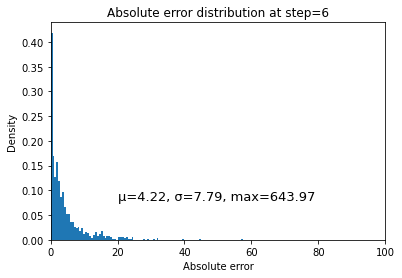

In [61]:
device = torch.device("cuda:0")
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = RNN.load_from_checkpoint(best_model_path).to(device)
print(best_model_path)
print(best_model.device)
predictions = best_model.predict(test_dataloader, batch_size=500, show_progress_bar=True)
print(predictions.shape)
actuals = torch.cat([y[0] for _, y in iter(test_dataloader)])
mask = actuals > 1.0
abs_error = torch.abs(predictions - actuals)
abs_error.shape
print(torch.mean(abs_error * mask))
abs_error_steps = torch.mean(abs_error * mask, dim=0)
abs_error_steps.shape
mape = abs_error / (actuals + 1e-5)
print(torch.mean(mape * mask))
mape_steps = torch.mean(mape * mask, dim=0)
n = abs_error.shape[0]
step = 6 # 30 mins later

abs_error_step = abs_error[:, step-1] * mask[:, step-1]

σ, μ = torch.std_mean(abs_error_step)
print(f"μ = {μ:.4f}, σ = {σ:.4f}, max = {abs_error_step.max():.4f}, error rate = {μ/carpark_data_HDB.groupby(['sid'])['AvailableLots'].max().mean():.4f}")
xs = abs_error_step[torch.randperm(n)[:1000]].cpu().numpy()
n = len(abs_error_step)
plt.hist(xs, 100, density=True)
plt.xlim(0, 100)
plt.xlabel("Absolute error")
plt.ylabel("Density")
plt.text(20, 0.08, f"μ={μ:.2f}, σ={σ:.2f}, max={abs_error_step.max():.2f}",
         fontsize=13)
plt.title(f"Absolute error distribution at step={step}");

NON-HDB Model

In [62]:
context_length = 12*12
prediction_length = 2*12

training_cutoff = 17*24*12
validation_cutoff = 19*24*12
test_cutoff = 21*24*12

training = TimeSeriesDataSet(
    carpark_data_non_HDB[lambda x: x.tid <= training_cutoff],
    time_idx="tid",
    group_ids=["sid"],
    target="AvailableLots",
    time_varying_unknown_reals=["AvailableLots"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    time_varying_known_categoricals=["min", "Weekday"],
)

validation = TimeSeriesDataSet.from_dataset(
    training,                                         
    carpark_data_non_HDB[lambda x: x.tid <= validation_cutoff],
    min_prediction_idx=training_cutoff + 1
)

test = TimeSeriesDataSet.from_dataset(
    training, 
    carpark_data_non_HDB,
    min_prediction_idx=validation_cutoff + 1
)

In [63]:
train_sampler = subset_sampler(training, 0.5, random=True)
val_sampler = subset_sampler(validation, 0.05)
test_sampler = subset_sampler(test, 0.05)
batch_size = 200
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, 
                                          num_workers=8)                                          
val_dataloader = validation.to_dataloader(batch_size=500, num_workers=8,
                                          shuffle=False, sampler=val_sampler)                                          
test_dataloader = test.to_dataloader(batch_size=500, num_workers=8,
                                     shuffle=False, sampler=test_sampler)   
actuals = torch.cat([y[0] for _, y in iter(test_dataloader)])
mask = actuals > 1.0
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, 
                                    patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=50,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=500
)

rnn = RNN.from_dataset(
    training,
    embedding_sizes={"min": (1440 // 5, 91), "Weekday": (7, 20)},
    # embedding_sizes={"min": (1440 // 5, 91)},
    cell_type="GRU",
    hidden_size=50,
    learning_rate=1e-3,
    log_interval=50,
    log_val_interval=50,
    weight_decay=1e-3,
)

#rnn

trainer.fit(
    rnn,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAE            | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 26.3 K
3 | rnn              | GRU            | 39.9 K
4 | output_projector | Linear         | 51    
----------------------------------------------------
66.3 K    Trainable params
0         Non-trainable params
66.3 K    Total params
0.265     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home_nfs/jiangyue/github/carpark-prediction/lightning_logs/version_71/checkpoints/epoch=8-step=4499.ckpt
cuda:0


Predict:   0%|          | 0/6 [00:00<?, ? batches/s]

torch.Size([3000, 24])
tensor(9.5039)
tensor(0.1906)
μ = 5.9705, σ = 14.5551, max = 261.7812, error rate = 0.0194


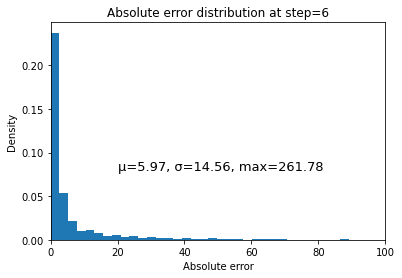

In [64]:
device = torch.device("cuda:0")
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = RNN.load_from_checkpoint(best_model_path).to(device)
print(best_model_path)
print(best_model.device)
predictions = best_model.predict(test_dataloader, batch_size=500, show_progress_bar=True)
print(predictions.shape)
actuals = torch.cat([y[0] for _, y in iter(test_dataloader)])
mask = actuals > 1.0
abs_error = torch.abs(predictions - actuals)
abs_error.shape
print(torch.mean(abs_error * mask))
abs_error_steps = torch.mean(abs_error * mask, dim=0)
abs_error_steps.shape
mape = abs_error / (actuals + 1e-5)
print(torch.mean(mape * mask))
mape_steps = torch.mean(mape * mask, dim=0)
n = abs_error.shape[0]
step = 6 # 30 mins later

abs_error_step = abs_error[:, step-1] * mask[:, step-1]

σ, μ = torch.std_mean(abs_error_step)
print(f"μ = {μ:.4f}, σ = {σ:.4f}, max = {abs_error_step.max():.4f}, error rate = {μ/carpark_data_non_HDB.groupby(['sid'])['AvailableLots'].max().mean():.4f}")
xs = abs_error_step[torch.randperm(n)[:1000]].cpu().numpy()
n = len(abs_error_step)
plt.hist(xs, 100, density=True)
plt.xlim(0, 100)
plt.xlabel("Absolute error")
plt.ylabel("Density")
plt.text(20, 0.08, f"μ={μ:.2f}, σ={σ:.2f}, max={abs_error_step.max():.2f}",
         fontsize=13)
plt.title(f"Absolute error distribution at step={step}");

Calculate the average carpark volume

In [139]:
print(carpark_data_HDB.groupby(['sid'])['AvailableLots'].max().mean())
print(carpark_data_non_HDB.groupby(['sid'])['AvailableLots'].max().mean())
print(carpark_data.groupby(['sid'])['AvailableLots'].max().mean())

255.40707364341085
308.239837398374
258.9330801229879
